<a href="https://colab.research.google.com/github/elifsare/Intrusion-Detection/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Extraction
https://www.kaggle.com/datasets/hassan06/nslkdd/data

In [ ]:
## kaggle key importing
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hassan06/nslkdd

In [ ]:
!mkdir dataset
!unzip '/content/nslkdd.zip' -d dataset

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import regularizers

import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.neural_network import MLPClassifier

In [ ]:
train_data = pd.read_csv('/content/dataset/KDDTrain+.txt')
test_data = pd.read_csv('/content/dataset/KDDTest+.txt')

## Explore Data

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        22543 non-null  int64  
 1   tcp      22543 non-null  object 
 2   private  22543 non-null  object 
 3   REJ      22543 non-null  object 
 4   0.1      22543 non-null  int64  
 5   0.2      22543 non-null  int64  
 6   0.3      22543 non-null  int64  
 7   0.4      22543 non-null  int64  
 8   0.5      22543 non-null  int64  
 9   0.6      22543 non-null  int64  
 10  0.7      22543 non-null  int64  
 11  0.8      22543 non-null  int64  
 12  0.9      22543 non-null  int64  
 13  0.10     22543 non-null  int64  
 14  0.11     22543 non-null  int64  
 15  0.12     22543 non-null  int64  
 16  0.13     22543 non-null  int64  
 17  0.14     22543 non-null  int64  
 18  0.15     22543 non-null  int64  
 19  0.16     22543 non-null  int64  
 20  0.17     22543 non-null  int64  
 21  0.18     225

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   0         125972 non-null  int64  
 1   tcp       125972 non-null  object 
 2   ftp_data  125972 non-null  object 
 3   SF        125972 non-null  object 
 4   491       125972 non-null  int64  
 5   0.1       125972 non-null  int64  
 6   0.2       125972 non-null  int64  
 7   0.3       125972 non-null  int64  
 8   0.4       125972 non-null  int64  
 9   0.5       125972 non-null  int64  
 10  0.6       125972 non-null  int64  
 11  0.7       125972 non-null  int64  
 12  0.8       125972 non-null  int64  
 13  0.9       125972 non-null  int64  
 14  0.10      125972 non-null  int64  
 15  0.11      125972 non-null  int64  
 16  0.12      125972 non-null  int64  
 17  0.13      125972 non-null  int64  
 18  0.14      125972 non-null  int64  
 19  0.15      125972 non-null  int64  
 20  0.16

In [ ]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
            'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

In [ ]:
train_data.columns = columns
test_data.columns = columns

In [ ]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22543 non-null  int64  
 1   protocol_type                22543 non-null  object 
 2   service                      22543 non-null  object 
 3   flag                         22543 non-null  object 
 4   src_bytes                    22543 non-null  int64  
 5   dst_bytes                    22543 non-null  int64  
 6   land                         22543 non-null  int64  
 7   wrong_fragment               22543 non-null  int64  
 8   urgent                       22543 non-null  int64  
 9   hot                          22543 non-null  int64  
 10  num_failed_logins            22543 non-null  int64  
 11  logged_in                    22543 non-null  int64  
 12  num_compromised              22543 non-null  int64  
 13  root_shell      

In [ ]:
test_data.to_csv('test.csv', index=False)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [ ]:
train_data.describe().style.background_gradient(cmap='Reds').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [ ]:
train_data.shape

(125972, 43)

In [ ]:

test_data.shape

(22543, 43)

In [ ]:
columns_with_missing_values = train_data.columns[train_data.isnull().any()].tolist()

if columns_with_missing_values:
    for col in columns_with_missing_values:
        print(f"missing col: {col}")
else:
    print("No missing value")

No missing value


In [ ]:
test_data.duplicated().sum()

0

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
train_data['outcome'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [ ]:
train_data['level'].unique()

array([15, 19, 21, 18, 20, 17, 16, 12, 14, 11,  2, 13, 10,  9,  8,  7,  3,
        5,  1,  6,  0,  4])

In [ ]:
for col in train_data.select_dtypes(include=['object']).columns:
  print(f"{col}: {train_data[col].nunique()}")

protocol_type: 3
service: 70
flag: 11
outcome: 23


In [ ]:
for col in test_data.select_dtypes(include=['object']).columns:
  print(f"{col}: {test_data[col].nunique()}")

protocol_type: 3
service: 64
flag: 11
outcome: 38


The 'service' column in the train and test data contains a different number of unique values. To address this discrepancy during model training, the columns in the training set will be adjusted to match those present in the test set.

## Data Processing

In [ ]:
def cat_col_manipulation(data):
  data['outcome'] = data.outcome.map(lambda x: 0 if x == 'normal' else 1)

  cat_col = data.select_dtypes(include=['object']).columns
  encoded_data = pd.get_dummies(data[cat_col], columns=cat_col, drop_first=True)
  encoded_data = encoded_data.astype(int)
  temp_data = data.drop(cat_col, axis=1)

  manipulated_data = pd.concat([temp_data, encoded_data], axis=1)

  return manipulated_data


In [ ]:
train_df = cat_col_manipulation(train_data)
test_df = cat_col_manipulation(test_data)

In [ ]:
test_df.shape

(22543, 115)

In [ ]:
train_df.shape

(125972, 121)

Equalizing columns between the train and test datasets.

In [ ]:
columns_to_drop = [col for col in train_df.columns if col not in test_df.columns]
train_df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
train_df.shape

(125972, 115)

## Data visulation

In [ ]:
def bar_plotter(df, col):
  counts = df[col].value_counts()

  plt.bar(counts.index, counts.values)

  plt.title(f'{col} Counts')
  plt.xlabel(col)
  plt.ylabel('Count')

  plt.xticks(counts.index)

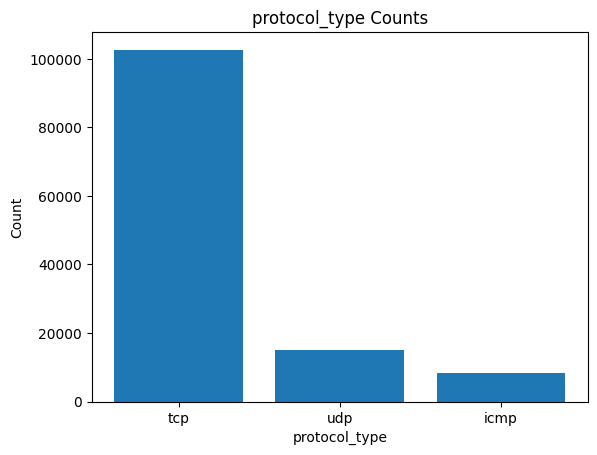

In [ ]:
bar_plotter(train_data, 'protocol_type')

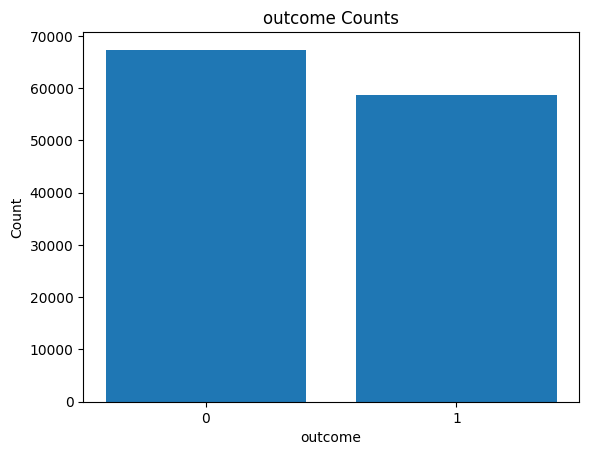

In [ ]:
bar_plotter(train_df, 'outcome')

Outliers value

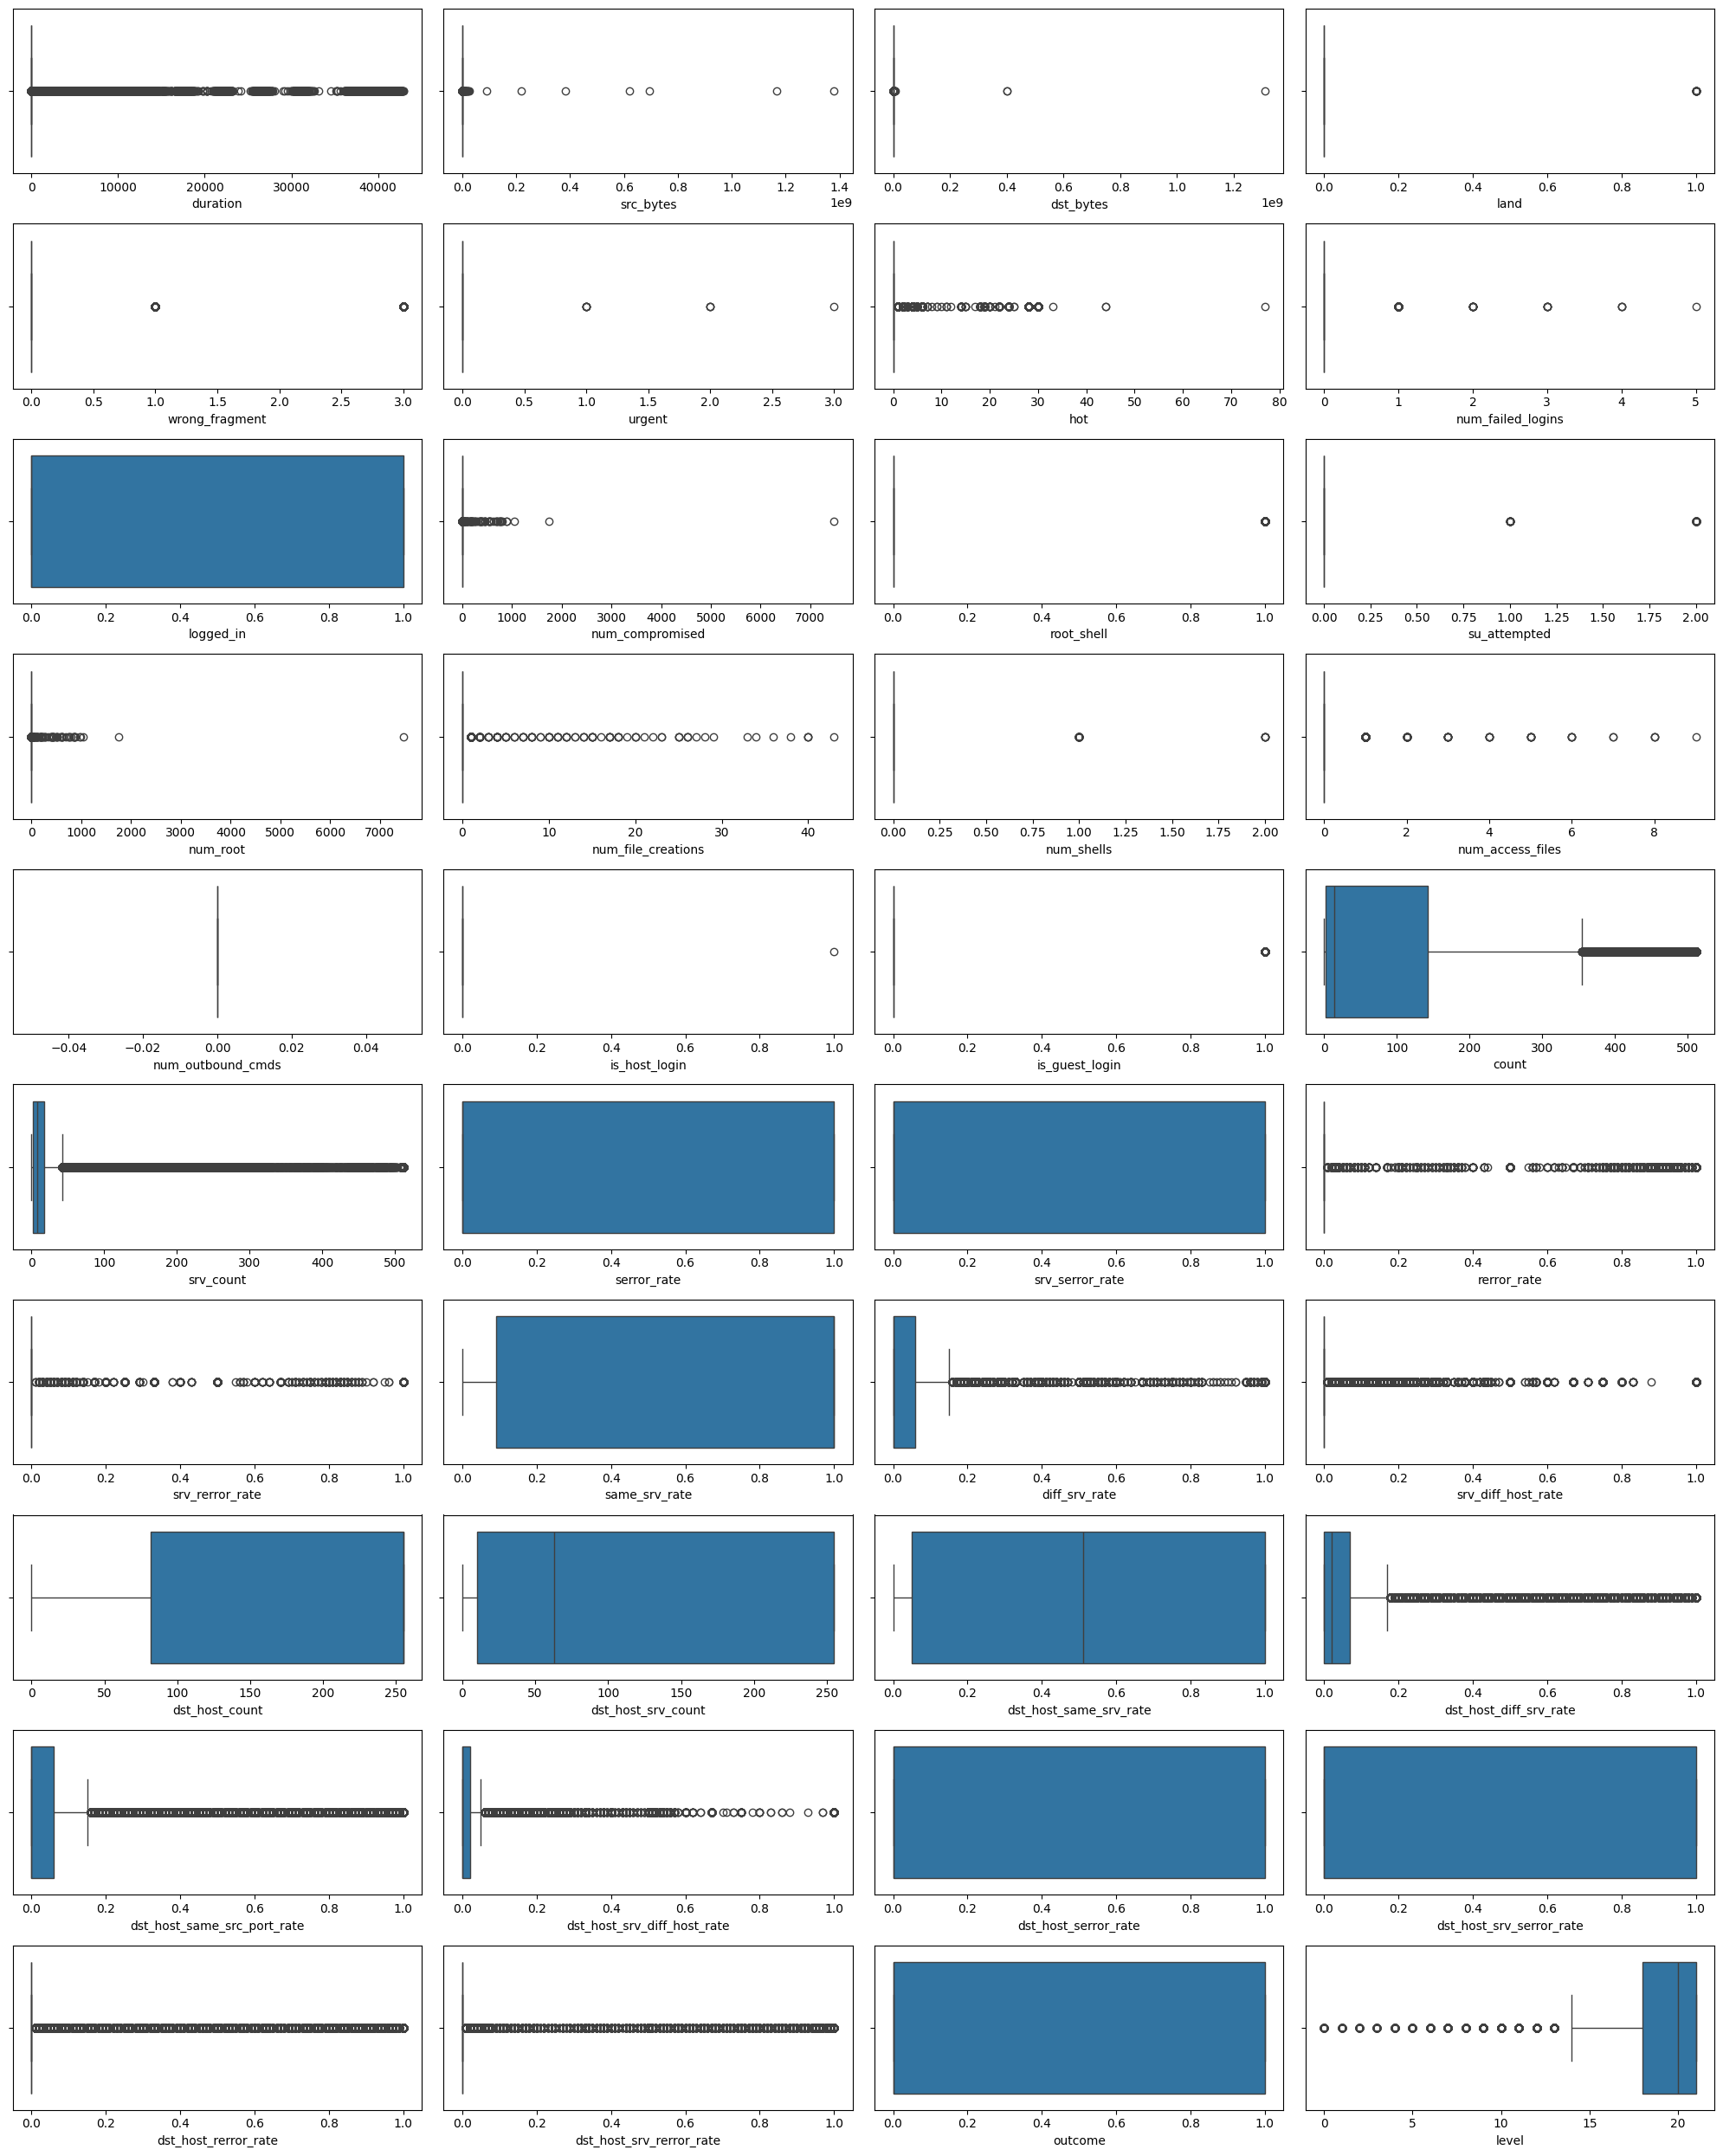

In [ ]:
num_col = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = train_data[num_col]

num_plots = len(num_col)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))
axes = axes.flatten()

for i, column in enumerate(numerical_data.columns):
    sns.boxplot(x = numerical_data[column], ax=axes[i])
    axes[i].set_xlabel(column)

for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
correlation_matrix = train_df.corr()


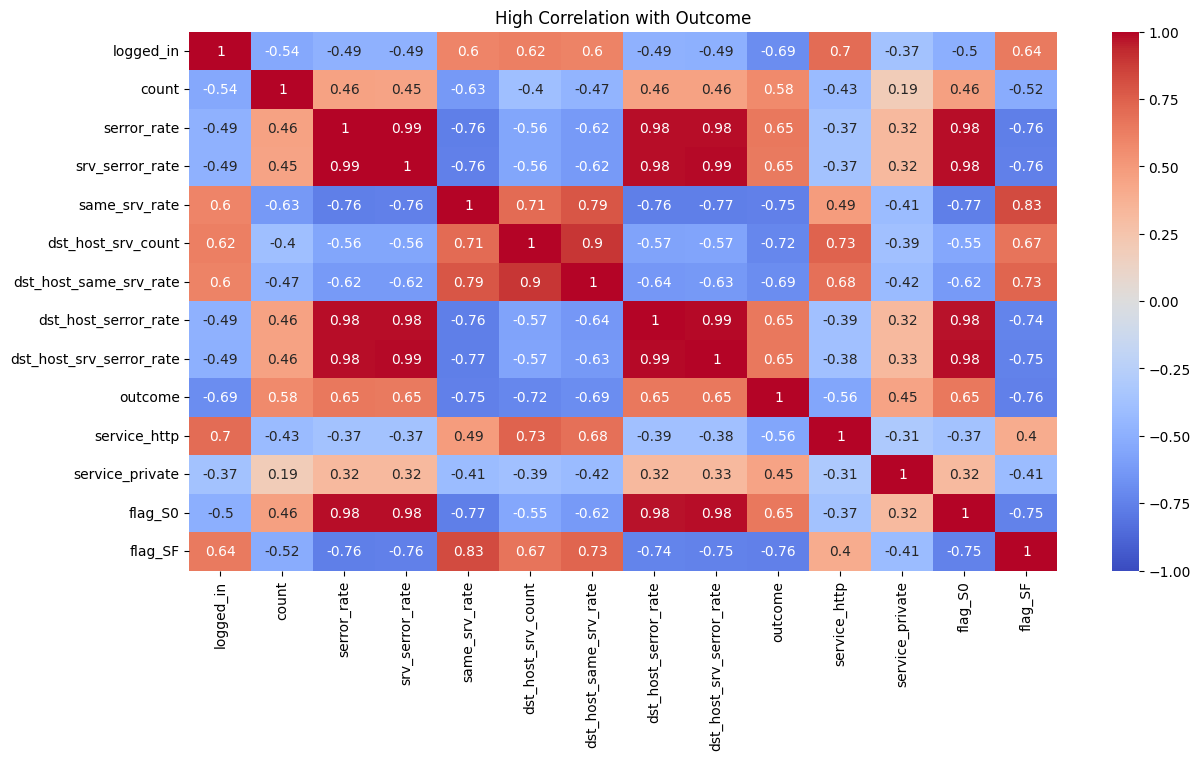

In [ ]:
selected_columns = correlation_matrix[abs(correlation_matrix['outcome']) >= 0.4].index.tolist()

plt.figure(figsize=(14, 7))
sns.heatmap(train_df[selected_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('High Correlation with Outcome')
plt.show()

## Scaling & PCA


In [ ]:
X_train = train_df.drop(['outcome', 'level'] , axis = 1).values
X_test = test_df.drop(['outcome', 'level'] , axis = 1).values

y_train = train_df['outcome'].values
y_test = test_df['outcome'].values


In [ ]:
X_train.shape,  X_test.shape, y_train.shape, y_test.shape


((125972, 113), (22543, 113), (125972,), (22543,))

In [ ]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


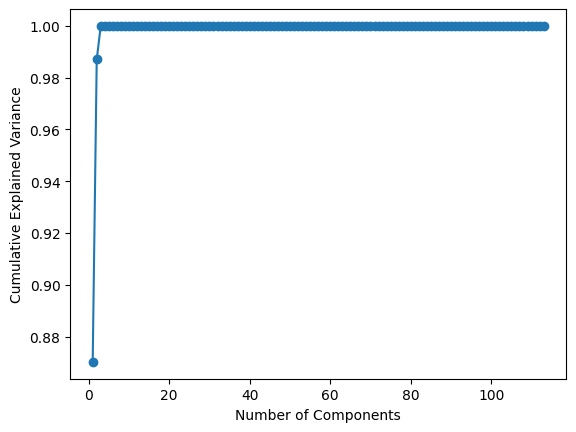

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Model Selection

In [ ]:
def train_and_evaluate_model(model_name, model, X_train, X_test, y_train, y_test, cv=10, metrics=None):

    if metrics is None:
        metrics = ['accuracy', 'precision', 'recall', 'f1']

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'cv_scores': cv_scores
    }

    return results

In [ ]:
def model_evaluation_plotter(model_name, model, X_test, y_test, figsize=(20, 5)):
    if model_name is None:
      model_name = 'model'

    y_scores = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=figsize)

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap=sns.cubehelix_palette(as_cmap=True))
    plt.ylabel('Actual', fontsize=13)
    plt.xlabel('Prediction', fontsize=13)
    plt.title(f"{model_name} Confusion Matrix")

    # ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc='lower right')

    # Precision - Recall
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} Precision-Recall Curve: AP={0:0.2f}".format(average_precision))

    plt.show()

### LinearSVC

In [ ]:
from sklearn import svm
lin_svm =svm.LinearSVC()
train_and_evaluate_model('LinearSVC', lin_svm, X_train_scaled, X_test_scaled, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

{'model': 'LinearSVC',
 'accuracy': 0.7614337044758905,
 'precision': 0.9116412635299315,
 'recall': 0.6432356608478803,
 'f1': 0.754272137439459,
 'cv_scores': array([0.9622956 , 0.96626449, 0.96300707, 0.971263  , 0.96467413,
        0.97443836, 0.96261015, 0.97110423, 0.96515043, 0.9668175 ])}

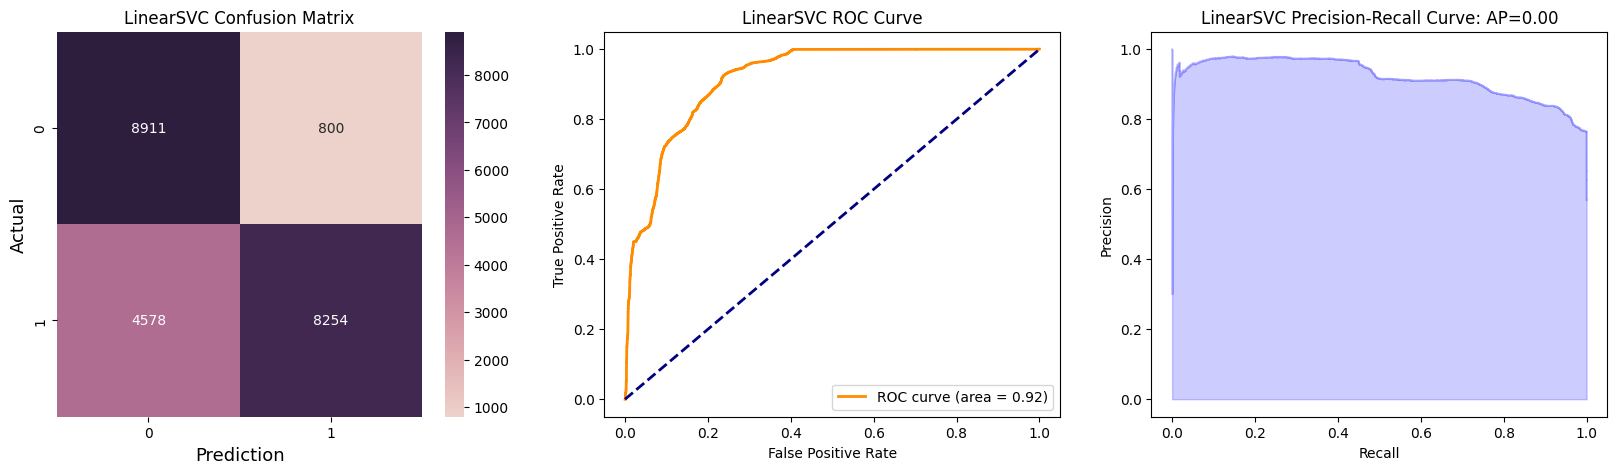

In [ ]:
def Linear_SVM_model_evaluation_plotter(model_name, model, X_test, y_test, figsize=(20, 5)):
    if model_name is None:
      model_name = 'model'

    y_scores = model.decision_function(X_test)

    plt.figure(figsize=figsize)

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap=sns.cubehelix_palette(as_cmap=True))
    plt.ylabel('Actual', fontsize=13)
    plt.xlabel('Prediction', fontsize=13)
    plt.title(f"{model_name} Confusion Matrix")

    # ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc='lower right')

    # Precision - Recall
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} Precision-Recall Curve: AP={0:0.2f}".format(average_precision))

    plt.show()

Linear_SVM_model_evaluation_plotter('LinearSVC', lin_svm, X_test_scaled, y_test)


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf_result = train_and_evaluate_model('Random Forest', rf, X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
rf_result

{'model': 'Random Forest',
 'accuracy': 0.7753626402874506,
 'precision': 0.9686293436293436,
 'recall': 0.6256234413965087,
 'f1': 0.7602272727272728,
 'cv_scores': array([0.99904747, 0.99880933, 0.99896801, 0.99912678, 0.99896801,
        0.99865047, 0.99880924, 0.99888862, 0.99928554, 0.99928554])}

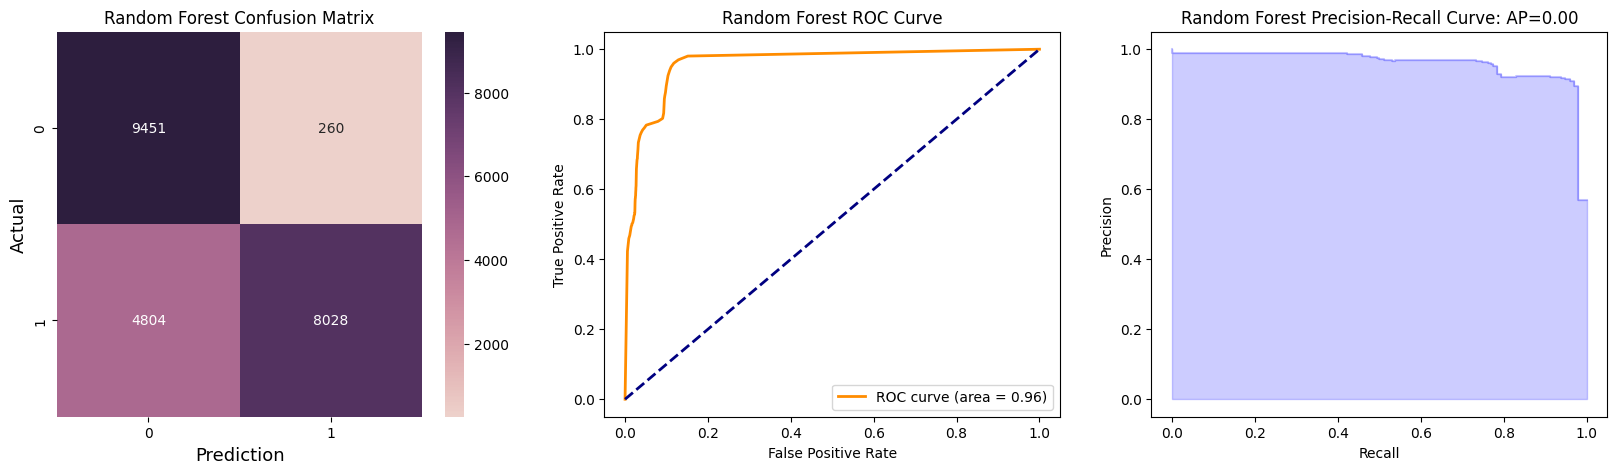

In [ ]:
model_evaluation_plotter('Random Forest', rf, X_test_scaled, y_test)

### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)
train_and_evaluate_model('DecisionTreeClassifier ', clf, X_train_scaled, X_test_scaled, y_train, y_test)

{'model': 'DecisionTreeClassifier ',
 'accuracy': 0.7969657986958257,
 'precision': 0.9604015616285555,
 'recall': 0.6709788029925187,
 'f1': 0.7900169748130476,
 'cv_scores': array([0.97356723, 0.97594856, 0.97427959, 0.9752322 , 0.97602604,
        0.97459713, 0.97308883, 0.97515281, 0.97340637, 0.9752322 ])}

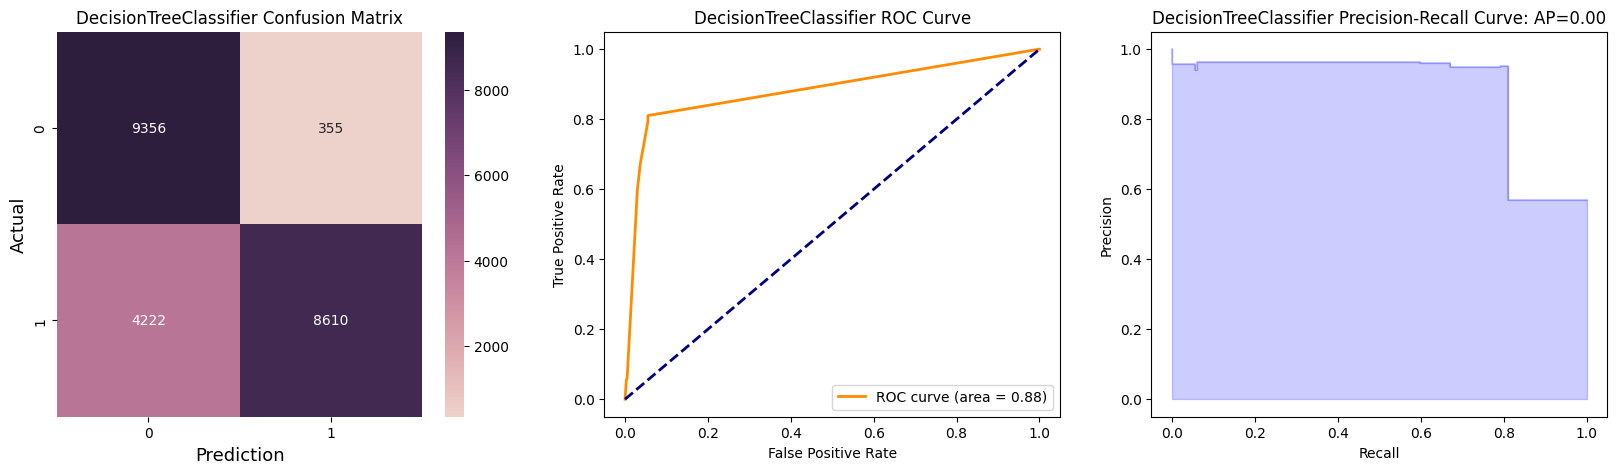

In [ ]:
model_evaluation_plotter('DecisionTreeClassifier', clf, X_test_scaled, y_test)


### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
train_and_evaluate_model('KNeighborsClassifier ', knn, X_train_scaled, X_test_scaled, y_train, y_test)

{'model': 'KNeighborsClassifier ',
 'accuracy': 0.7483476023599344,
 'precision': 0.9722918590843119,
 'recall': 0.5742674563591023,
 'f1': 0.7220616334329527,
 'cv_scores': array([0.99237974, 0.99277663, 0.99222037, 0.99253791, 0.99245852,
        0.99222037, 0.99293483, 0.9935699 , 0.99349051, 0.99412559])}

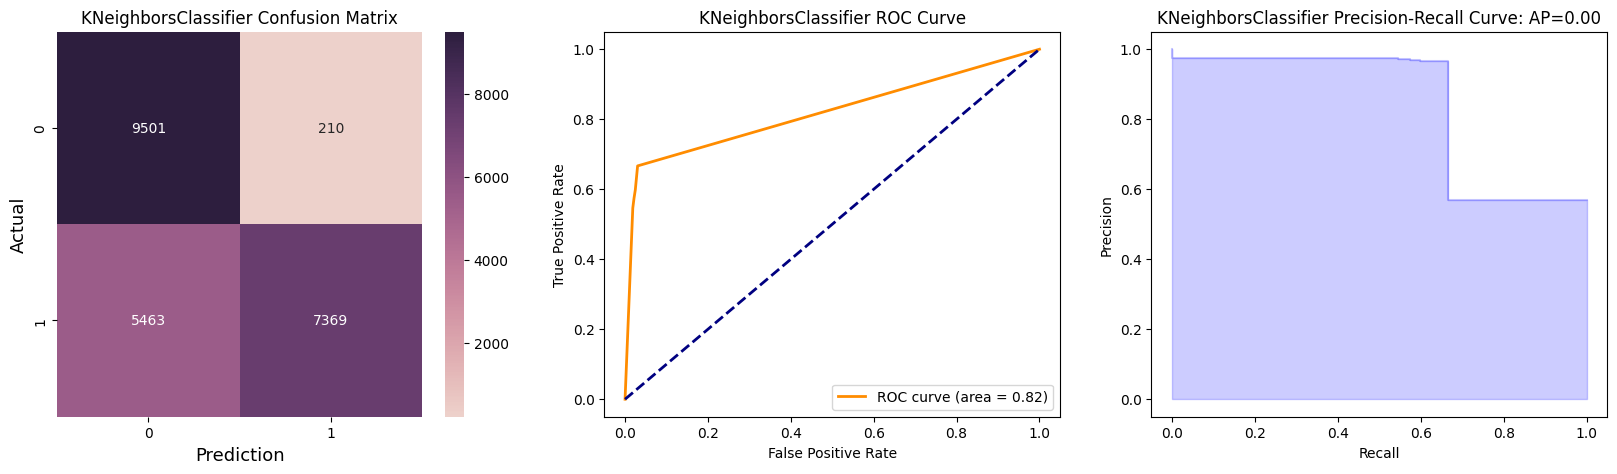

In [ ]:
model_evaluation_plotter('KNeighborsClassifier', knn, X_test_scaled, y_test)


### XGBRegressor

In [ ]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor()
XGB_reg.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = XGB_reg.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R²):", r2)

Mean Squared Error (MSE): 0.16677682746865077
Mean Absolute Error (MAE): 0.20187127871510324
R-squared Score (R²): 0.3198560721119157


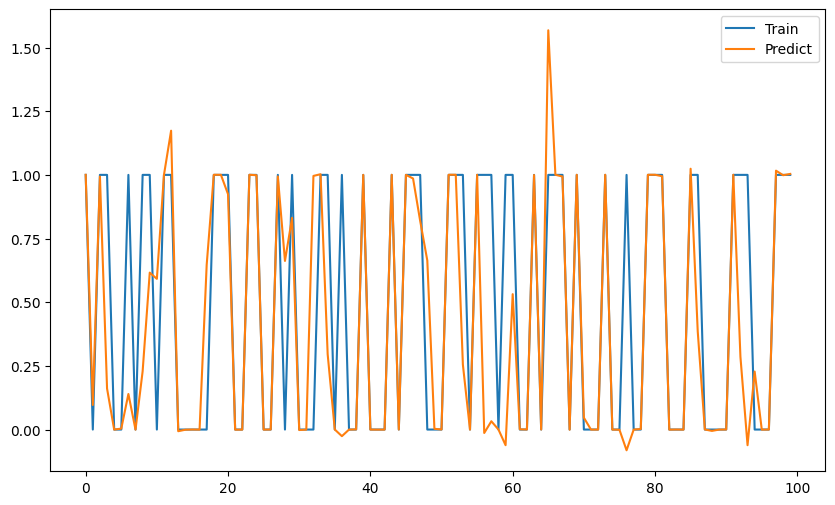

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Train')
plt.plot(y_pred[:100], label='Predict')
plt.legend()
plt.show()


### Logistic Reg

In [ ]:
LR = LogisticRegression()
train_and_evaluate_model('Logistic Regression', LR, X_train_scaled, X_test_scaled, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'model': 'Logistic Regression',
 'accuracy': 0.7715920684913277,
 'precision': 0.9301310043668122,
 'recall': 0.6473659600997507,
 'f1': 0.7634057804530625,
 'cv_scores': array([0.84330846, 0.86608986, 0.88132095, 0.8676669 , 0.85972851,
        0.86854013, 0.86441216, 0.8532984 , 0.86385647, 0.86147495])}

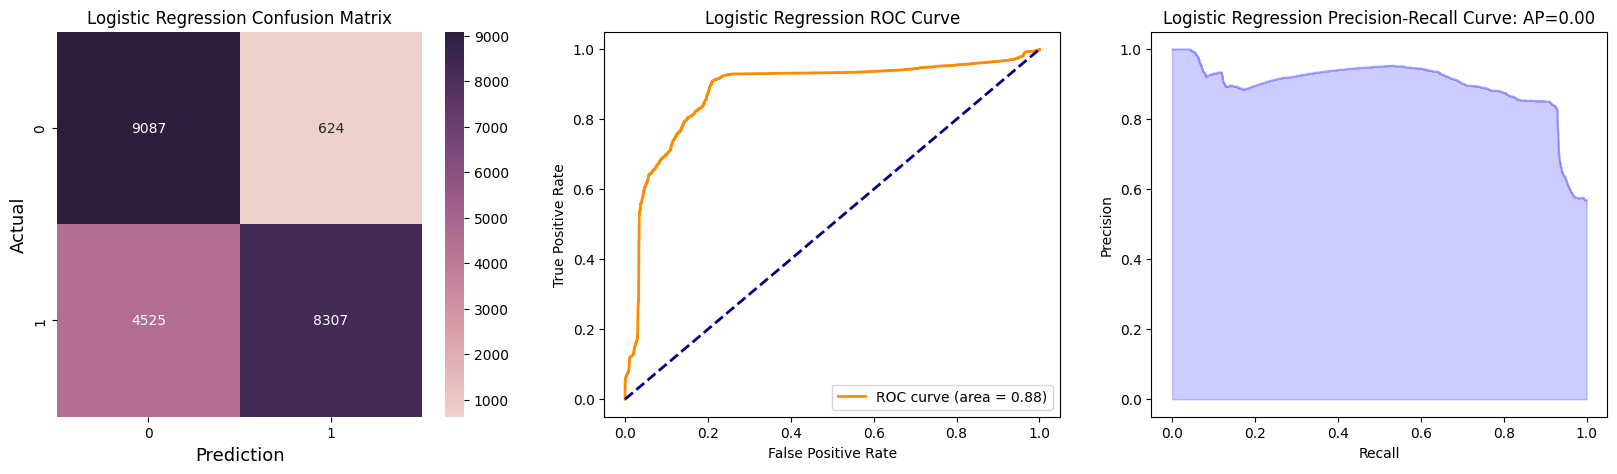

In [ ]:
model_evaluation_plotter('Logistic Regression', LR, X_test_scaled, y_test)

### MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(250, 500, 250)).fit(X_train_scaled, y_train)

In [ ]:
y_pred = mlp.predict(X_test_scaled)

print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision': {precision_score(y_test, y_pred)}")
print(f"recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")

accuracy: 0.7827263452069378
precision': 0.9270182992465016
recall: 0.6711346633416458
f1: 0.7785914474278998


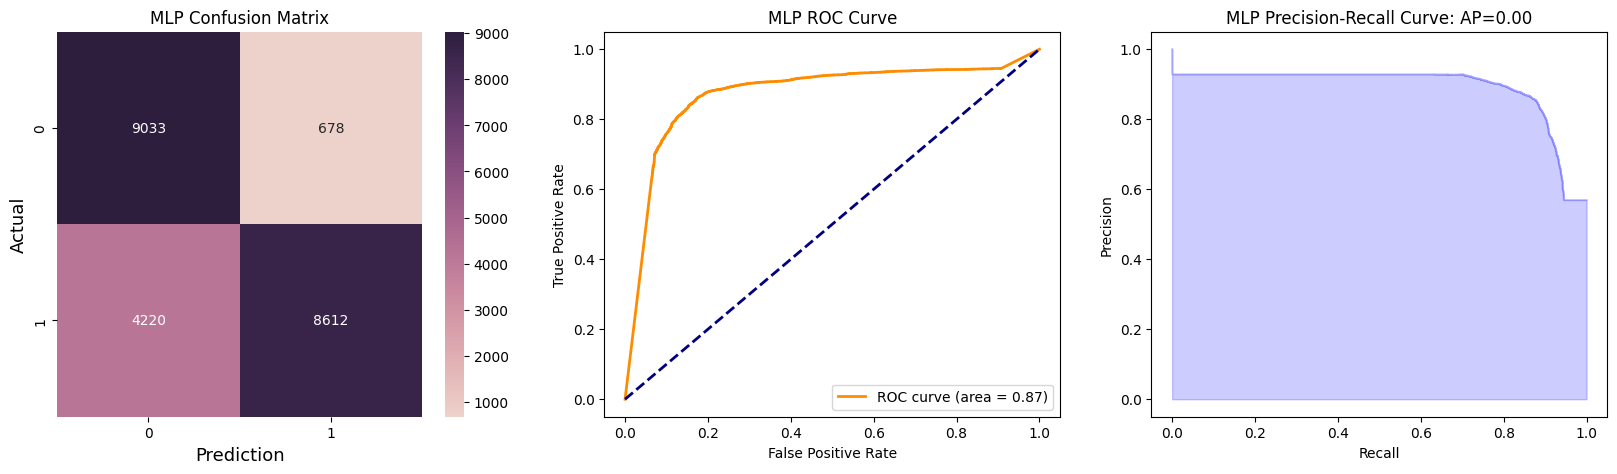

In [ ]:
model_evaluation_plotter("MLP", mlp, X_test_scaled, y_test)

## Model Tuning & Final Results
When evaluating the models, it appears that the results are similar, but the MLPClassifier has outperformed the other models. Additionally, the Random Forest Classifier performs well. Therefore, let's proceed with hyperparameter tuning.

In [ ]:
rf_classifier_tune = RandomForestClassifier()

In [ ]:
param_grid = {
    'n_estimators': [10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 10, 30],
}

grid_search = GridSearchCV(estimator=rf_classifier_tune, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_dt_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

print("En iyi model:", rf_classifier_tune)
print("En iyi hiperparametreler:", best_params)

En iyi model: RandomForestClassifier()
En iyi hiperparametreler: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 50}


In [ ]:

best_model = RandomForestClassifier(**best_params)
train_and_evaluate_model('Best RandomForestClassifier', best_model, X_train_scaled, X_test_scaled, y_train, y_test)

{'model': 'Best RandomForestClassifier',
 'accuracy': 0.7687086900589983,
 'precision': 0.9688577055637617,
 'recall': 0.6133884039900249,
 'f1': 0.7511929757587327,
 'cv_scores': array([0.99912685, 0.99872996, 0.99896801, 0.99896801, 0.99880924,
        0.99857109, 0.99880924, 0.99896801, 0.99888862, 0.99920616])}

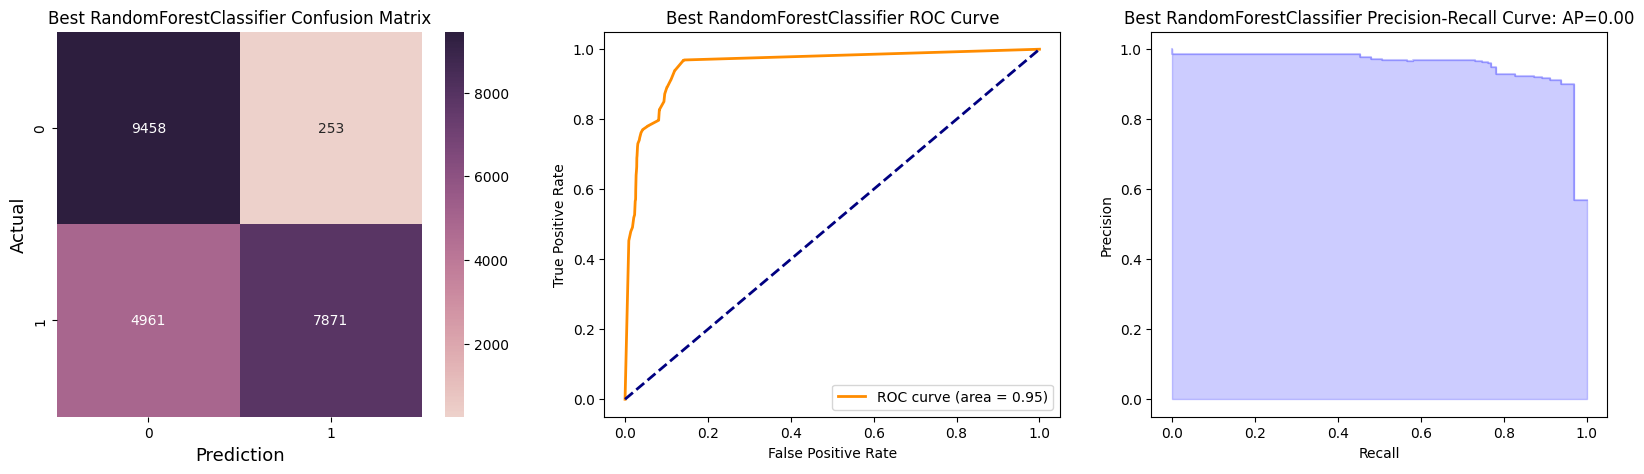

In [ ]:
model_evaluation_plotter('Best RandomForestClassifier', best_model, X_test_scaled, y_test)

Top features

In [ ]:
feature_names =train_df.columns

In [ ]:
feature_importances = best_model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
top_10_features = sorted_indices[:10]
top_feature_names = [feature_names[i] for i in top_10_features]


In [ ]:
top_feature_names

['src_bytes',
 'dst_bytes',
 'flag_S2',
 'dst_host_same_srv_rate',
 'dst_host_srv_count',
 'diff_srv_rate',
 'same_srv_rate',
 'count',
 'dst_host_same_src_port_rate',
 'flag_RSTOS0']

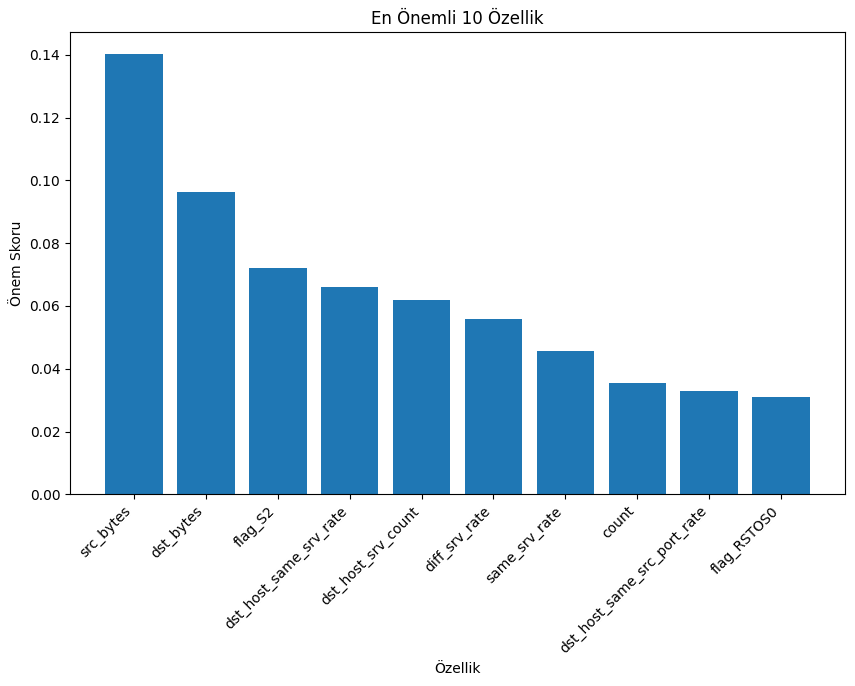

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_features)), feature_importances[top_10_features], tick_label=top_feature_names)
plt.title('En Önemli 10 Özellik')
plt.xlabel('Özellik')
plt.ylabel('Önem Skoru')
plt.xticks(rotation=45, ha='right')
plt.show()

## Model Save

In [ ]:
import joblib

filename = 'anomaly_detection_model_RFC.joblib'
joblib.dump(best_model, filename)

['anomaly_detection_model_RFC.joblib']

In [ ]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']